# Part 3: Predicting prices with KNN & Neural Networks
***

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
import keras.losses
import tensorflow as tf
from keras.layers import Dropout

***
## 1. Inputs & EDA

In [121]:
symbol = "GOOG"
df = pd.read_csv("~/Dropbox/Dev/Systrading/Data/{}.csv".format(symbol),
                index_col="date", #index on Dates
                parse_dates = True, #get time index objects
                dayfirst = True,) #AA/MM/DD or DD/MM/AA (International and European format)

In [122]:
df.head(3)

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
date,,,,,,,,,,,,
2014-03-27,558.46,568.00,552.92,568.00,13100,558.46,0,568.00,552.92,568.00,1,13100
2014-03-28,559.99,566.43,558.67,561.20,41100,559.99,0,566.43,558.67,561.20,1,41100
2014-03-31,556.97,567.00,556.93,566.89,10800,556.97,0,567.00,556.93,566.89,1,10800


***
## 2. Feature Engineering

**cf Part 1 for more details on the below**

In [123]:
df['5d_future_close'] = df['adjClose'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['adjClose'].pct_change(5)

In [124]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close and add it to the datafrane
    df['ma' + str(n)] = talib.SMA(df['adjClose'].values,
                              timeperiod=n) / df['adjClose']
    # Create the RSI indicator and add it to the datafrane
    df['rsi' + str(n)] = talib.RSI(df['adjClose'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [125]:
new_features = ['adjVolume_1d_change', 'adjVolume_1d_change_SMA']
feature_names.extend(new_features)
df['adjVolume_1d_change'] = df['adjVolume'].pct_change()
df['adjVolume_1d_change_SMA'] = talib.SMA(df['adjVolume_1d_change'].values, timeperiod=5)

In [126]:
df = df.dropna()

In [127]:
features = df[feature_names]
targets = df['5d_close_future_pct']
features.head(3)

,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,adjVolume_1d_change,adjVolume_1d_change_SMA
date,,,,,,,,,,,
2015-01-12,-0.041489,1.049719,30.751389,1.056865,37.363452,1.076069,40.743968,1.121577,47.018047,0.129195,0.097507
2015-01-13,-0.011515,1.037910,34.332484,1.046066,38.850271,1.066015,41.572871,1.112729,47.192372,0.019497,0.019847
2015-01-14,-0.000459,1.023953,38.740366,1.034079,40.730669,1.053709,42.630880,1.101749,47.417029,-0.057509,0.065925


***
## 3. KNN model

**Train-test split for time-series data** by **manually** creating a size for the training set that is 85% of the total number of samples

In [128]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
features.shape, train_features.shape, test_features.shape

((842, 11), (715, 11), (127, 11))

We need **scaled data** for models like KNN & Neural Networks: we will **standardize our data**, which sets the mean to 0 and standard deviation to 1

In [129]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

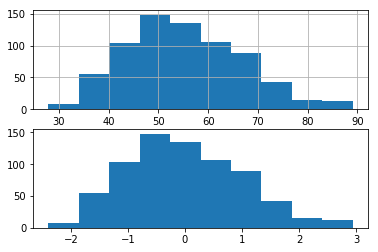

In [130]:
#Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

**Create and fit various KNN model by tuning the hyperparameter n, the number of neighbors**

In [131]:
for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train score =', knn.score(scaled_train_features, train_targets))
    print('test score =', knn.score(scaled_test_features, test_targets), "\n")

n_neighbors = 2
train score = 0.6307750584377001
test score = 0.029450676142418475 

n_neighbors = 3
train score = 0.4519428871389326
test score = 0.04322578081621897 

n_neighbors = 4
train score = 0.37768505722223966
test score = 0.06304623074628268 

n_neighbors = 5
train score = 0.3222397912933459
test score = 0.021166366342483034 

n_neighbors = 6
train score = 0.28873849134657004
test score = 0.040782754370599084 

n_neighbors = 7
train score = 0.26307179665411995
test score = 0.04818258907508999 

n_neighbors = 8
train score = 0.23286731416647166
test score = 0.03639002472304731 

n_neighbors = 9
train score = 0.23526196782342257
test score = 0.051009062689371665 

n_neighbors = 10
train score = 0.21866121884638268
test score = 0.04052600695325825 

n_neighbors = 11
train score = 0.20051486643650118
test score = 0.03459922907918167 

n_neighbors = 12
train score = 0.19542350831142086
test score = 0.041494426890322234 



**Choose and Fit model for n = 4**

In [132]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [133]:
# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

**Assess model** - Scatter actuals vs predictions

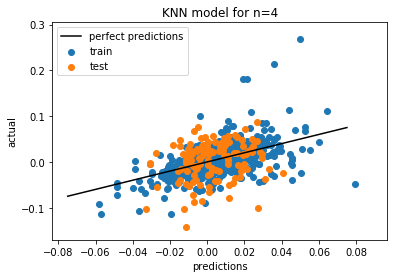

In [134]:
# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.05), np.arange(xmin, xmax, 0.05), c='k', label='perfect predictions')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('KNN model for n=4')
plt.legend()
plt.show()

***
## 3. Neural Networks model

**Create and fit a simple 3-layer net model**

In [135]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
715/715 [==============================] - 1s 872us/step - loss: 0.0727
Epoch 2/25
715/715 [==============================] - 0s 63us/step - loss: 0.0102
Epoch 3/25
715/715 [==============================] - 0s 58us/step - loss: 0.0049
Epoch 4/25
715/715 [==============================] - 0s 57us/step - loss: 0.0035
Epoch 5/25
715/715 [==============================] - 0s 64us/step - loss: 0.0030
Epoch 6/25
715/715 [==============================] - 0s 122us/step - loss: 0.0027
Epoch 7/25
715/715 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 8/25
715/715 [==============================] - 0s 53us/step - loss: 0.0021
Epoch 9/25
715/715 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 10/25
715/715 [==============================] - 0s 46us/step - loss: 0.0018
Epoch 11/25
715/715 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 12/25
715/715 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 13/25

**Examine the training loss curve to make sure it's flattened out**

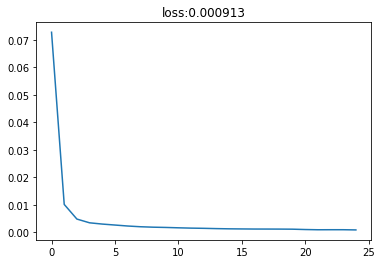

In [136]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Assess model** - R^2 score and Scatter actuals vs predictions

In [137]:
# Calculate R^2 score
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)
r2_score(train_targets, train_pred1), r2_score(test_targets, test_pred1)

(0.22175947650707462, -0.6173553971782815)

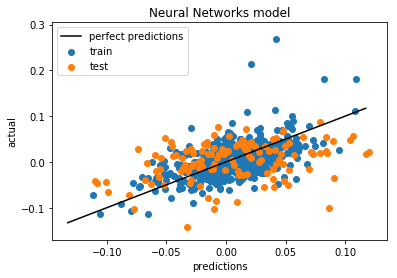

In [138]:
# Plot predictions vs actual
plt.scatter(train_pred1, train_targets, label='train')
plt.scatter(test_pred1, test_targets, label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.05), np.arange(xmin, xmax, 0.05), c='k', label='perfect predictions')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('Neural Networks model')
plt.legend()
plt.show()

It doesn't look too much different from our other models at this point...

***
## 4. Neural Networks with Custom loss function model

Up to now, we've used the mean squared error as a loss function. <br>
Let's now **implement a custom loss function**. It can help improve our model's performance in specific ways we choose. <br>For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our neural network learn to at least predict price movements in the correct direction.

In [139]:
# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  #enable use of loss with keras
keras.losses.sign_penalty

<function __main__.sign_penalty(y_true, y_pred)>

**Create and fit a neural network with our custom loss function**

In [140]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
715/715 [==============================] - 1s 857us/step - loss: 2.3376
Epoch 2/25
715/715 [==============================] - 0s 94us/step - loss: 0.5561
Epoch 3/25
715/715 [==============================] - 0s 70us/step - loss: 0.2619
Epoch 4/25
715/715 [==============================] - 0s 56us/step - loss: 0.2012
Epoch 5/25
715/715 [==============================] - 0s 52us/step - loss: 0.1490
Epoch 6/25
715/715 [==============================] - 0s 69us/step - loss: 0.1315
Epoch 7/25
715/715 [==============================] - 0s 78us/step - loss: 0.1060
Epoch 8/25
715/715 [==============================] - 0s 52us/step - loss: 0.0968
Epoch 9/25
715/715 [==============================] - 0s 51us/step - loss: 0.0872
Epoch 10/25
715/715 [==============================] - 0s 52us/step - loss: 0.0689
Epoch 11/25
715/715 [==============================] - 0s 51us/step - loss: 0.0806
Epoch 12/25
715/715 [==============================] - 0s 51us/step - loss: 0.0722
Epoch 13/25


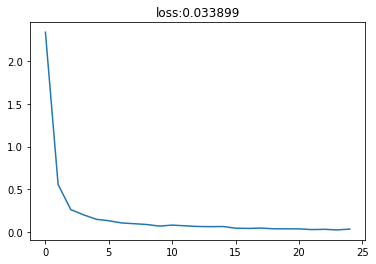

In [141]:
# Plot the losses from the fit
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Assess model** - R^2 score and Scatter actuals vs predictions

In [142]:
# Evaluate R^2 scores
train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)
r2_score(train_targets, train_pred2), r2_score(test_targets, test_pred2)

(-0.09728091320482068, -0.4380151171968243)

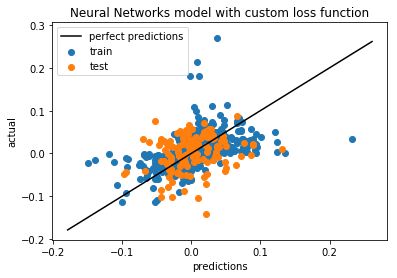

In [143]:
# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_pred2, train_targets, label='train')
plt.scatter(test_pred2, test_targets, label='test')  # plot test set

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect predictions')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('Neural Networks model with custom loss function')
plt.legend(); plt.show()

***
##  5. Neural Networks model with dropout

A common problem with neural networks is they tend to overfit to training data. <br>
We can work towards **preventing overfitting by using dropout**. This randomly drops some neurons during the training phase, which helps prevent the net from fitting noise in the training data. keras has a Dropout layer that we can use to accomplish this. We need to set the dropout rate, or fraction of connections dropped during training time. This is set as a decimal between 0 and 1 in the Dropout() layer. <br>
<br>
We're going to go back to the mean squared error loss function for this model.

In [144]:
# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
715/715 [==============================] - 1s 875us/step - loss: 0.0420
Epoch 2/25
715/715 [==============================] - 0s 62us/step - loss: 0.0210
Epoch 3/25
715/715 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 4/25
715/715 [==============================] - 0s 52us/step - loss: 0.0079
Epoch 5/25
715/715 [==============================] - 0s 58us/step - loss: 0.0054
Epoch 6/25
715/715 [==============================] - 0s 55us/step - loss: 0.0047
Epoch 7/25
715/715 [==============================] - 0s 65us/step - loss: 0.0037
Epoch 8/25
715/715 [==============================] - 0s 57us/step - loss: 0.0031
Epoch 9/25
715/715 [==============================] - 0s 57us/step - loss: 0.0021
Epoch 10/25
715/715 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 11/25
715/715 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 12/25
715/715 [==============================] - 0s 54us/step - loss: 0.0023
Epoch 13/25


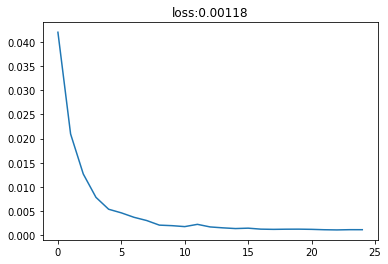

In [145]:
# Plot the losses from the fit
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Assess model** - R^2 score and Scatter actuals vs predictions

In [146]:
# Evaluate R^2 scores
train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)
r2_score(train_targets, train_pred3), r2_score(test_targets, test_pred3)

(0.06930706405207876, 0.10539168770508711)

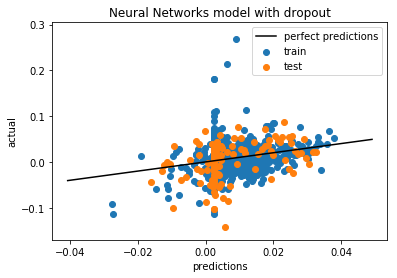

In [147]:
# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_pred3, train_targets, label='train')
plt.scatter(test_pred3, test_targets, label='test')  # plot test set

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect predictions')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('Neural Networks model with dropout')
plt.legend(); plt.show()

***
## 6. Ensembling our three Neural Networks models

**Horizontally stack predictions** from the 3 neural net models and **take the average across rows**

In [148]:
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
test_preds[-5:]

array([ 0.00826533,  0.00383919,  0.00315901, -0.00406626, -0.01775392],
      dtype=float32)

**Assess model** - R^2 score and Scatter actuals vs predictions

In [149]:
# Evaluate the R^2 scores
r2_score(train_targets, train_preds),r2_score(test_targets, test_preds)

(0.36374862913451844, 0.12490358442069704)

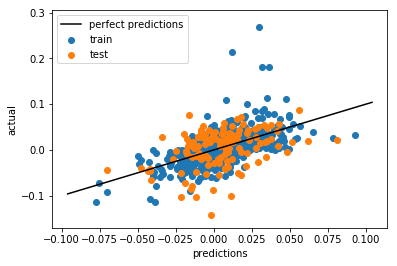

In [150]:
# Scatter the predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect predictions')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend(); plt.show()